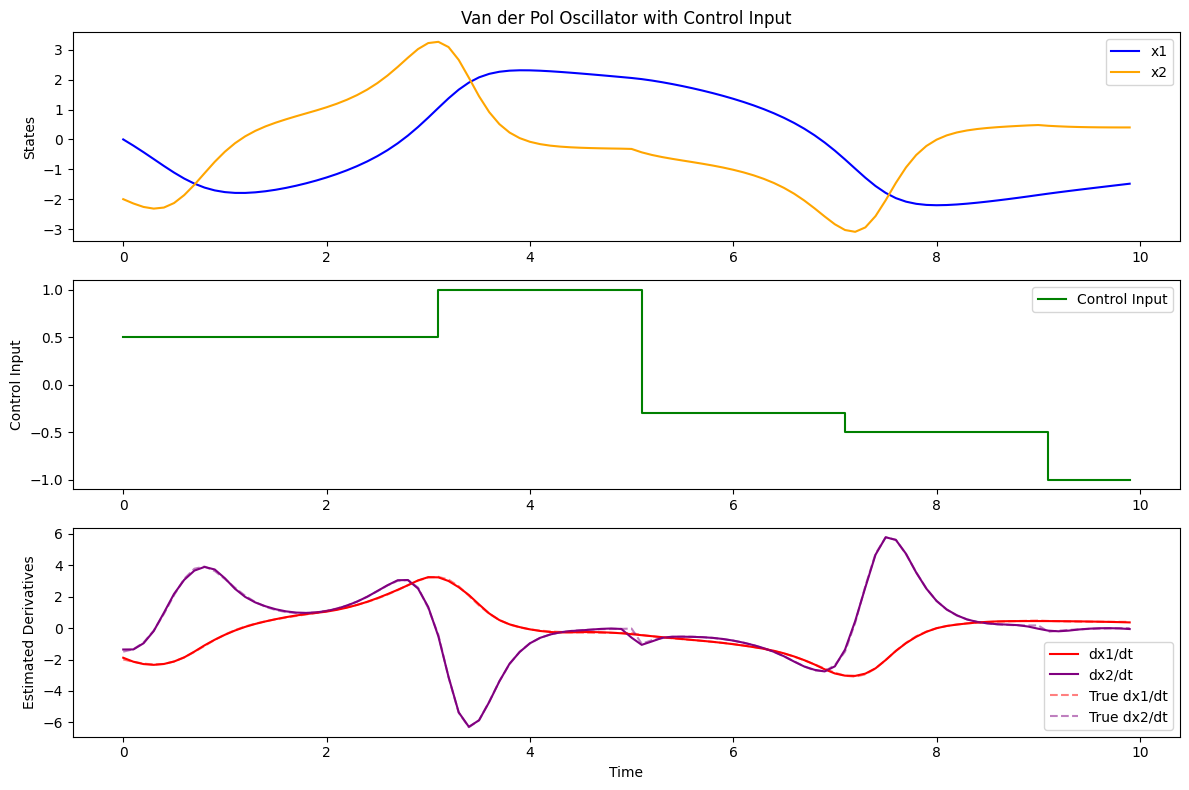

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter
from sklearn.kernel_ridge import KernelRidge

MU = 1.0
T_START, T_END = 0.0, 10.0
dt = 0.1
y0 = [0, -2]
SAVGOL_FILTER = False

# Time-varying control input
def control_input(t):
    control_values = [(3, 0.5), (5, 1.0), (7, -0.3), (9, -0.5)]
    for threshold, value in control_values:
        if t <= threshold:
            return value
    return -1

# Van der Pol with control
def vanderpol(t, x, mu=MU):
    u = control_input(t)
    dx1 = x[1]
    dx2 = mu * (1 - x[0] ** 2) * x[1] - x[0] + u
    return [dx1, dx2]

# Simulate the system
t_eval = np.arange(T_START, T_END, dt)
sol = solve_ivp(vanderpol, [T_START, T_END], y0, t_eval=t_eval)
x1 = sol.y[0]
x2 = sol.y[1]
t = sol.t
u = np.array([control_input(ti) for ti in t])
data = pd.DataFrame({'t': t, 'x1': x1, 'x2': x2, 'u': u})   

if SAVGOL_FILTER:
    dx1_est = savgol_filter(x1, window_length=11, polyorder=3, deriv=1, delta=dt)
    dx2_est = savgol_filter(x2, window_length=11, polyorder=3, deriv=1, delta=dt)
else:        
    spline_x1 = UnivariateSpline(t, x1, s=1e-3)
    spline_x2 = UnivariateSpline(t, x2, s=1e-3)

    dx1_est = spline_x1.derivative()(t)
    dx2_est = spline_x2.derivative()(t)
    
dx1_true = []
dx2_true = []
for xi1, xi2, ti in zip(x1, x2, t):
    dx = vanderpol(ti, [xi1, xi2], mu=MU)
    dx1_true.append(dx[0])
    dx2_true.append(dx[1])

dx1_true = np.array(dx1_true)
dx2_true = np.array(dx2_true)

# Plotting
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(t, x1, label='x1', color='blue')
plt.plot(t, x2, label='x2', color='orange')
plt.title('Van der Pol Oscillator with Control Input')
plt.ylabel('States')
plt.legend()
plt.subplot(3, 1, 2)
plt.step(t, u, label='Control Input', color='green', where='post')
plt.ylabel('Control Input')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(t, dx1_est, label='dx1/dt', color='red')
plt.plot(t, dx2_est, label='dx2/dt', color='purple')
plt.plot(t, dx1_true, label='True dx1/dt', linestyle='--', color='red', alpha=0.5)
plt.plot(t, dx2_true, label='True dx2/dt', linestyle='--', color='purple', alpha=0.5)
plt.ylabel('Estimated Derivatives')
plt.xlabel('Time')
plt.legend()
plt.tight_layout()
plt.show()



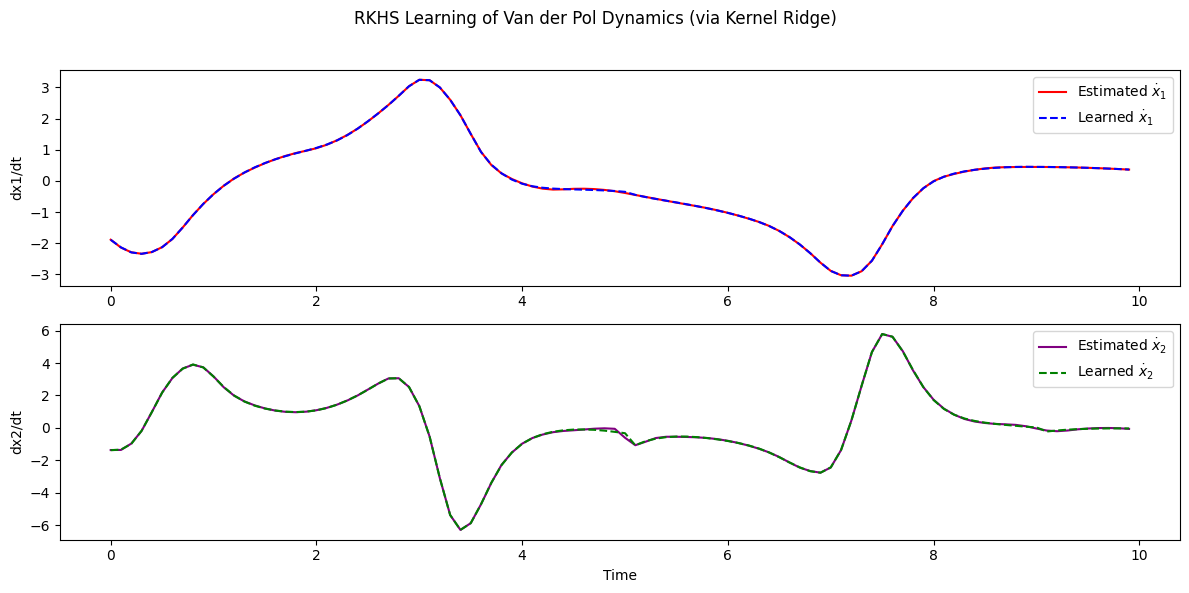

In [19]:
X_train = data[['x1', 'x2', 'u']].values
y1_train = dx1_est
y2_train = dx2_est

krr_f1 = KernelRidge(kernel='rbf', alpha=0.0001, gamma=0.5)
krr_f2 = KernelRidge(kernel='rbf', alpha=0.0001, gamma=0.5)
krr_f1.fit(X_train, y1_train)
krr_f2.fit(X_train, y2_train)

# Predict on the training data
dx1_pred = krr_f1.predict(X_train)
dx2_pred = krr_f2.predict(X_train)

# Plot estimated vs learned derivatives
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, dx1_est, label='Estimated $\dot{x}_1$', color='red')
plt.plot(t, dx1_pred, '--', label='Learned $\dot{x}_1$', color='blue')
plt.ylabel('dx1/dt')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, dx2_est, label='Estimated $\dot{x}_2$', color='purple')
plt.plot(t, dx2_pred, '--', label='Learned $\dot{x}_2$', color='green')
plt.ylabel('dx2/dt')
plt.xlabel('Time')
plt.legend()

plt.suptitle("RKHS Learning of Van der Pol Dynamics (via Kernel Ridge)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


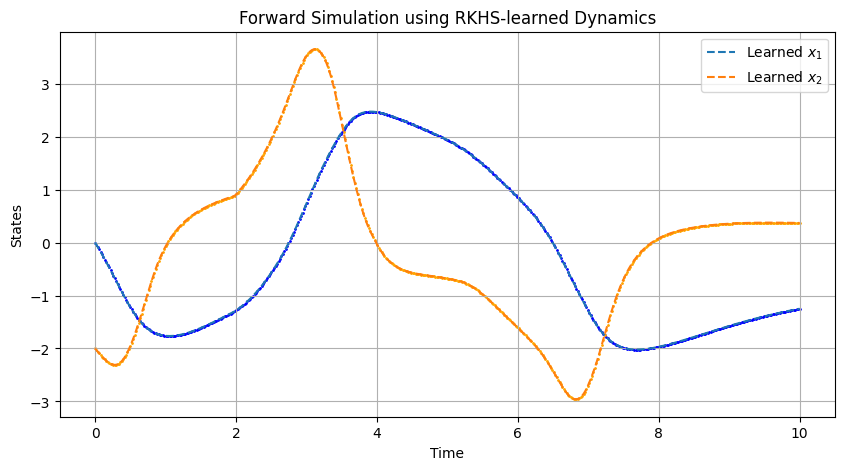

In [32]:
def control_input(t):
    control_values = [(2, 0.3), (4, 0.9), (5.1, -0.2), (7, 0.2)]
    for threshold, value in control_values:
        if t <= threshold:
            return value
    return -1

def learned_dynamics(t, x):
    u = control_input(t)
    input_vec = np.array([[x[0], x[1], u]])
    dx1 = krr_f1.predict(input_vec)[0]
    dx2 = krr_f2.predict(input_vec)[0]
    return [dx1, dx2]

x0_learned = [0, -2]
t_span = (0, 10)
t_eval = np.linspace(*t_span, 500)

sol_learned = solve_ivp(learned_dynamics, t_span, x0_learned, t_eval=t_eval)
x1_learned = sol_learned.y[0]
x2_learned = sol_learned.y[1]  # Extract the second state variable from the solution

sol_true = solve_ivp(vanderpol, t_span, x0_learned, t_eval=t_eval)
x1_true = sol_true.y[0]
x2_true = sol_true.y[1]  # Extract the second state variable from the solution

plt.figure(figsize=(10, 5))
plt.plot(t_eval, x1_learned, label="Learned $x_1$", linestyle='--')
plt.plot(t_eval, x2_learned, label="Learned $x_2$", linestyle='--')
plt.scatter(t_eval, x1_learned, color='blue', s=1)
plt.scatter(t_eval, x2_learned, color='orange', s=1)

plt.xlabel("Time")
plt.ylabel("States")
plt.title("Forward Simulation using RKHS-learned Dynamics")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
stio

NameError: name 'stio' is not defined

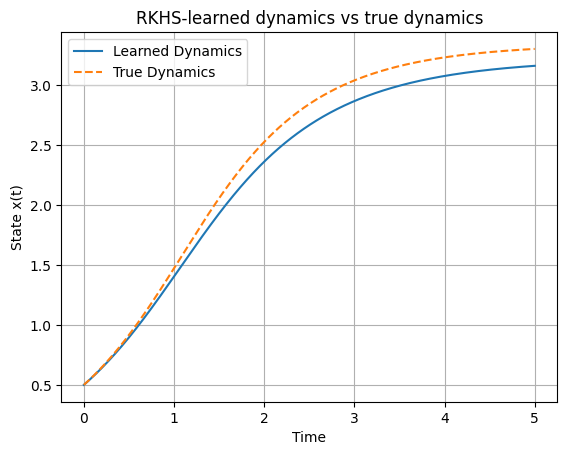

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.kernel_ridge import KernelRidge


# 1. Generate training data from the nonlinear system: dx/dt = sin(x) + u
def true_dynamics(x, u):
    return np.sin(x) + u

# Sample data
np.random.seed(42)
N = 15
x_data = np.random.uniform(-3, 3, N)
u_data = np.random.uniform(-1, 1, N)
x_dot_data = true_dynamics(x_data, u_data) + 0.1 * np.random.randn(N)  # add noise

# Stack inputs: (x, u)
X_train = np.vstack((x_data, u_data)).T
y_train = x_dot_data

# 2. Train a kernel ridge regression model (RKHS approach)
model = KernelRidge(alpha=1e-2, kernel='rbf', gamma=0.10)  # Gaussian kernel
model.fit(X_train, y_train)

# 3. Simulate the system using learned dynamics
def learned_dynamics(x, u):
    return model.predict(np.array([[x, u]]))[0]

# Simulate trajectory with learned dynamics
x0 = 0.5
u_const = 0.2  # constant input
T = 5.0
dt = 0.01
timesteps = int(T / dt)
x_traj = [x0]
for t in range(timesteps):
    x_curr = x_traj[-1]
    dxdt = learned_dynamics(x_curr, u_const)
    x_next = x_curr + dt * dxdt
    x_traj.append(x_next)

# True trajectory (for comparison)
x_true = [x0]
for t in range(timesteps):
    x_curr = x_true[-1]
    dxdt = true_dynamics(x_curr, u_const)
    x_next = x_curr + dt * dxdt
    x_true.append(x_next)

# Plotting
time = np.linspace(0, T, timesteps + 1)
plt.plot(time, x_traj, label='Learned Dynamics')
plt.plot(time, x_true, label='True Dynamics', linestyle='--')
plt.xlabel('Time')
plt.ylabel('State x(t)')
plt.legend()
plt.title('RKHS-learned dynamics vs true dynamics')
plt.grid(True)
plt.show()


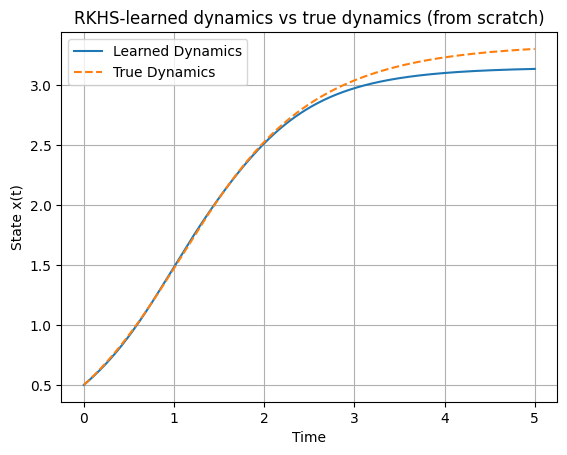

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Step 1: Define true system dynamics
def true_dynamics(x, u):
    return np.sin(x) + u

# Step 2: Generate training data
np.random.seed(42)
N = 100
x_data = np.random.uniform(-3, 3, N)
u_data = np.random.uniform(-1, 1, N)
X_train = np.vstack((x_data, u_data)).T  # shape: (N, 2)
y_train = true_dynamics(x_data, u_data) + 0.1 * np.random.randn(N)  # noisy derivative

# Step 3: Define RBF kernel
def rbf_kernel(X1, X2, gamma=1.0):
    # ||x - x'||^2 = x^2 + x'^2 - 2 x·x'
    X1_sq = np.sum(X1**2, axis=1).reshape(-1, 1)
    X2_sq = np.sum(X2**2, axis=1).reshape(1, -1)
    dist_sq = X1_sq + X2_sq - 2 * X1 @ X2.T
    return np.exp(-gamma * dist_sq)

# Step 4: Compute kernel matrix K and solve for alpha
lambda_reg = 1e-2
gamma = 1.0

K = rbf_kernel(X_train, X_train, gamma=gamma)
alpha = np.linalg.solve(K + lambda_reg * np.eye(N), y_train)

# Step 5: Define learned dynamics
def learned_dynamics(x, u):
    x_query = np.array([[x, u]])
    k_vec = rbf_kernel(X_train, x_query, gamma=gamma).flatten()
    return np.dot(alpha, k_vec)

# Step 6: Simulate learned and true dynamics
x0 = 0.5
u_const = 0.2
T = 5.0
dt = 0.01
steps = int(T / dt)

x_learned = [x0]
x_true = [x0]

for _ in range(steps):
    # Learned model
    x_curr = x_learned[-1]
    dxdt = learned_dynamics(x_curr, u_const)
    x_learned.append(x_curr + dt * dxdt)

    # True model
    x_curr_true = x_true[-1]
    dxdt_true = true_dynamics(x_curr_true, u_const)
    x_true.append(x_curr_true + dt * dxdt_true)

# Step 7: Plotting
time = np.linspace(0, T, steps + 1)
plt.plot(time, x_learned, label="Learned Dynamics")
plt.plot(time, x_true, label="True Dynamics", linestyle="--")
plt.xlabel("Time")
plt.ylabel("State x(t)")
plt.title("RKHS-learned dynamics vs true dynamics (from scratch)")
plt.legend()
plt.grid(True)
plt.show()
